In [1]:
from __future__ import division
import sys, os
sys.path.append("../")
from past.utils import old_div
from sippy import functionset as fset
from sippy import *
import numpy as np
import control.matlab as cnt
import matplotlib.pyplot as plt
# from matplotlib import rcParams

# rcParams['figure.figsize'] = (9.0, 5.0)

## Define sampling time and Time vector

In [2]:
sampling_time = 1.  # [s]
end_time = 400  # [s]
npts = int(old_div(end_time, sampling_time)) + 1
Time = np.linspace(0, end_time, npts)

## Define pseudo random binary sequence as input signal and white noise as noise signal

In [3]:
# make input signal
switch_probability = 0.08  # [0..1]
Usim = fset.GBN_seq(npts, switch_probability)

# make noise for input signal
white_noise_variance = [0.005]
e_t = fset.white_noise_var(Usim[0].size, white_noise_variance)[0]

## Define the system

### Numerator of noise transfer function has only one root: nc = 1

In [4]:
NUM_H = [1., 0.3, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

### Common denominator between input and noise transfer functions has 4 roots: na = 4

In [5]:
DEN = [1., -2.21, 1.7494, -0.584256, 0.0684029, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

### Numerator of input transfer function has 3 roots: nb = 3

In [6]:
NUM = [1., -2.07, 1.3146]

### Define transfer functions

In [7]:
g_sample = cnt.tf(NUM, DEN, sampling_time)
h_sample = cnt.tf(NUM_H, DEN, sampling_time)
print("g()")
display(g_sample)
print("h()")
display(h_sample)

g()


TransferFunction(array([ 1.    , -2.07  ,  1.3146]), array([ 1.       , -2.21     ,  1.7494   , -0.584256 ,  0.0684029,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ]), 1.0)

h()


TransferFunction(array([1. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ]), array([ 1.       , -2.21     ,  1.7494   , -0.584256 ,  0.0684029,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ]), 1.0)

## Time responses

### Input reponse

/home/lex/anaconda3/envs/38/lib/python3.8/site-packages/control/timeresp.py:917: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


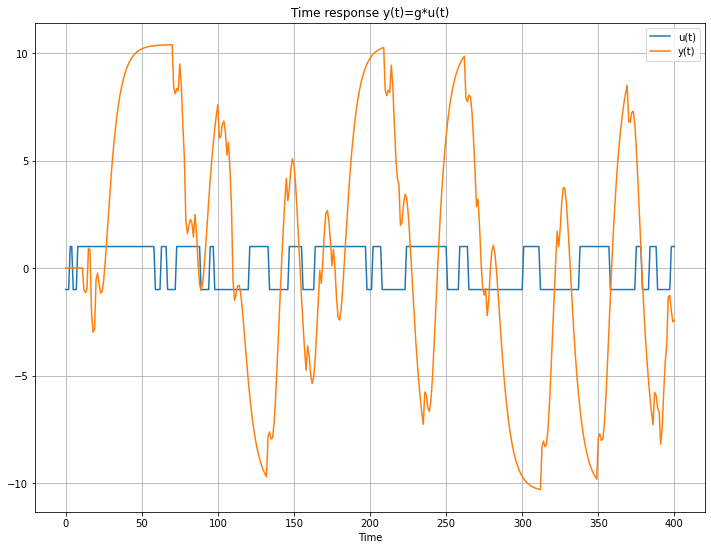

In [9]:
Y1, Time, Xsim = cnt.lsim(g_sample, Usim[0], Time)
plt.figure(figsize=(12,9))
plt.plot(Time, Usim[0], label="u(t)")
plt.plot(Time, Y1, label="y(t)")
plt.xlabel("Time")
plt.title("Time response y(t)=g*u(t)")
plt.legend()
plt.grid()
plt.show()

### Noise response

/home/lex/anaconda3/envs/38/lib/python3.8/site-packages/control/timeresp.py:917: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


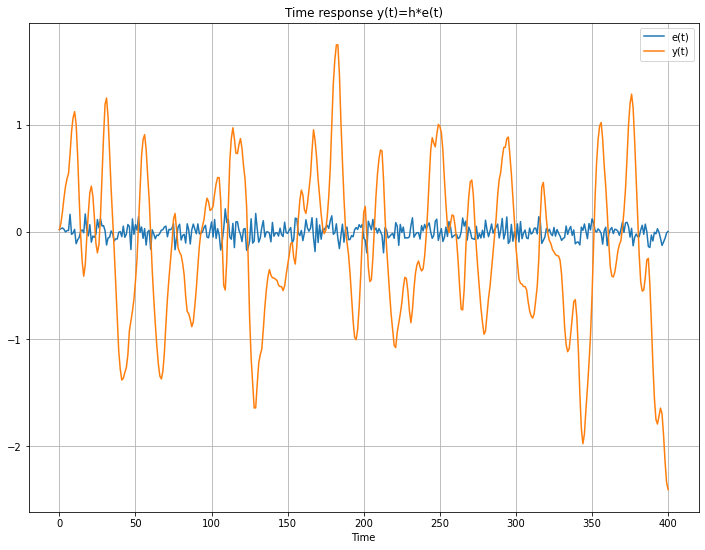

In [10]:
Y2, Time, Xsim = cnt.lsim(h_sample, e_t, Time)
plt.figure(figsize=(12,9))
plt.plot(Time, e_t, label="e(t)")
plt.plot(Time, Y2, label="y(t)")
plt.xlabel("Time")
plt.title("Time response of y(t)=h*e(t)")
plt.legend()
plt.grid()

## Compute total output 
$$Y_t = Y_1 + Y_2 = G.u + H.e$$

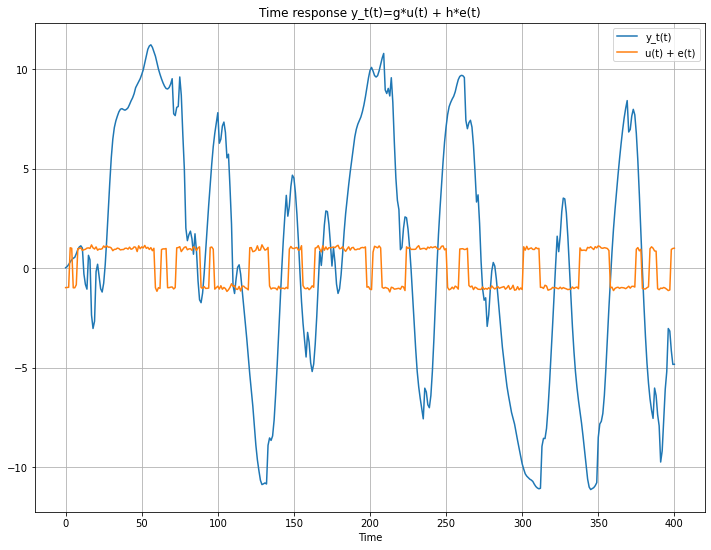

In [14]:
Ytot = Y1 + Y2
Utot = Usim[0] + e_t
plt.figure(figsize=(12,9))
plt.plot(Time, Ytot, label="y_t(t)")
plt.plot(Time, Utot, label="u(t) + e(t)")
plt.xlabel("Time")
plt.title("Time response y_t(t)=g*u(t) + h*e(t)")
plt.legend()
plt.grid()

## Perform system identification from collected data

In [18]:
Id_sys = system_identification(Ytot, Usim[0], 'ARMAX', IC='BIC', na_ord=[2, 5], \
                               nb_ord=[1, 5], nc_ord=[0, 2], delays=[10, 13], \
                               max_iterations=1000)

Armax model:
- Params:
  na: 4 (2, 5)
  nb: 4 (1, 5)
  nc: 2 (0, 2)
  delay: 10 (10, 13)
  dt: 1.0 
  method: BIC 
  max iterations: 1000 
- Output:
  G: 
        -0.008092 z^3 + 1.01 z^2 - 2.085 z + 1.335
-----------------------------------------------------------
z^14 - 2.209 z^13 + 1.753 z^12 - 0.5868 z^11 + 0.06659 z^10

dt = 1.0
 
  H: 
             z^14 + 0.3451 z^13 - 0.03485 z^12
-----------------------------------------------------------
z^14 - 2.209 z^13 + 1.753 z^12 - 0.5868 z^11 + 0.06659 z^10

dt = 1.0
 
  Vn: 0.00011564134434127304 
  Model Output: [[  0.02057659   0.07928023   0.18334263   0.31308182   0.4211061
    0.49486752   0.54243061   0.72382072   0.93558185   1.06497224
    1.12082237   1.00570231  -0.28960588  -0.82318638  -1.06265673
    0.62820826   0.40927001  -2.51799815  -3.00822284  -2.65558111
   -0.23094374   0.2546461   -0.38820338  -0.98141322  -1.1693475
   -0.86385203   0.14141814   1.3164362    2.82029782   4.22114729
    5.54256622   6.59987053   7

## Check that output of the identified system is consistent

In [19]:
Y_id1, Time, Xsim = cnt.lsim(Id_sys.G, Usim[0], Time)
Y_hid1, Time, Xsim = cnt.lsim(Id_sys.H, e_t, Time)
Y_idTot = Y_id1 + Y_hid1

/home/lex/anaconda3/envs/38/lib/python3.8/site-packages/control/timeresp.py:917: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


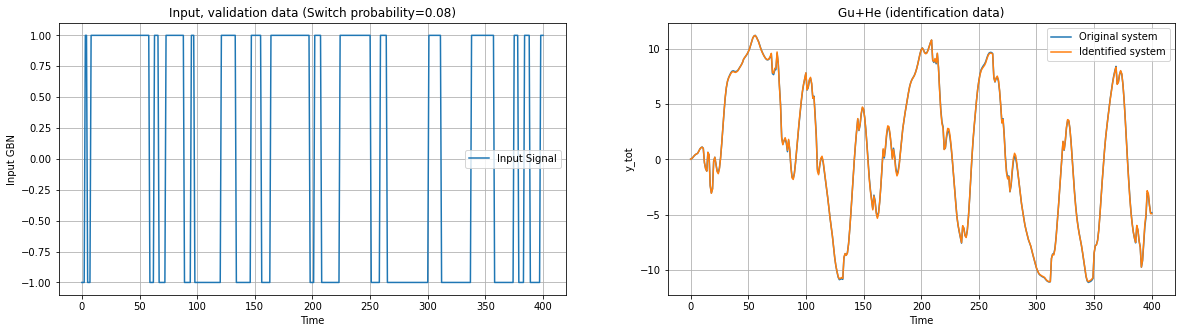

In [31]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
ax.plot(Time, Usim[0], label="Input Signal")
ax.set_title("Input, validation data (Switch probability=0.08)")
ax.set_ylabel("Input GBN")
ax.set_xlabel("Time")
ax.grid()
ax.legend()

ax = fig.add_subplot(122)
ax.plot(Time, Ytot, label="Original system")
ax.plot(Time, Y_idTot, label="Identified system")
ax.set_xlabel("Time")
ax.set_ylabel("y_tot")
ax.set_title("Gu+He (identification data)")
ax.grid()
ax.legend()
plt.show()

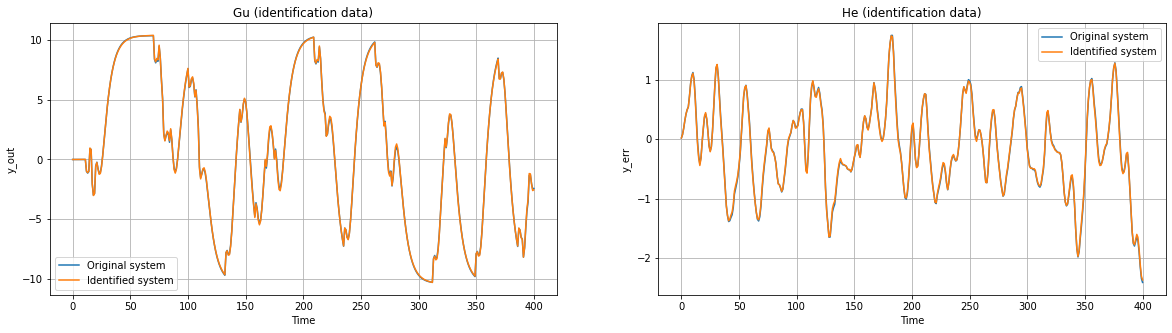

In [32]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
ax.plot(Time, Y1, label="Original system")
ax.plot(Time, Y_id1, label="Identified system")
ax.set_title("Gu (identification data)")
ax.set_ylabel("y_out")
ax.set_xlabel("Time")
ax.grid()
ax.legend()


ax = fig.add_subplot(122)
ax.plot(Time, Y2, label="Original system")
ax.plot(Time, Y_hid1, label="Identified system")
ax.set_xlabel("Time")
ax.set_ylabel("y_err")
ax.set_title("He (identification data)")
ax.grid()
plt.legend()
plt.show()

# Validation of the identified system: 
## Generate new time series for input and noise

In [34]:
switch_probability = 0.07  # [0..1]
input_range = [0.5, 1.5]
U_valid = fset.GBN_seq(npts, switch_probability, Range=input_range)
white_noise_variance = [0.01]
e_valid = fset.white_noise_var(U_valid[0].size, white_noise_variance)[0]

## Compute time responses for true system with new inputs

In [36]:
Yvalid1, Time, Xsim = cnt.lsim(g_sample, U_valid[0], Time)
Yvalid2, Time, Xsim = cnt.lsim(h_sample, e_valid, Time)
Ytotvalid = Yvalid1 + Yvalid2

## Compute time responses for identified system with new inputs

In [37]:
Yidvalid1, Time, Xsim = cnt.lsim(Id_sys.G, U_valid[0], Time)
Yidvalid2, Time, Xsim = cnt.lsim(Id_sys.H, e_valid, Time)
Yidtotvalid = Yidvalid1 + Yidvalid2

## Check responses are almost equal

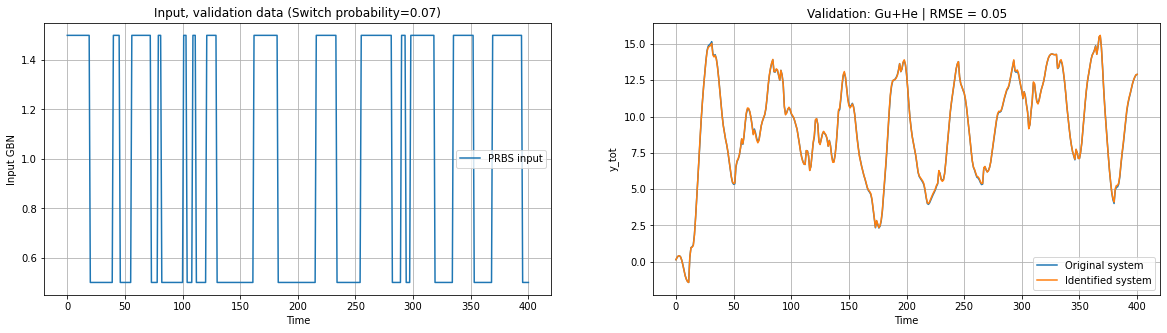

In [40]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
ax.plot(Time, U_valid[0], label="PRBS input")
ax.set_title("Input, validation data (Switch probability=0.07)")
ax.set_ylabel("Input GBN")
ax.set_xlabel("Time")
ax.grid()
ax.legend()


ax = fig.add_subplot(122)
ax.plot(Time, Ytotvalid)
ax.plot(Time, Yidtotvalid)
ax.set_xlabel("Time")
ax.set_ylabel("y_tot")
ax.legend(['Original system', 'Identified system'])
plt.grid()

rmse = np.round(np.sqrt(np.mean((Ytotvalid-Yidtotvalid)**2)), 2)
ax.set_title("Validation: Gu+He | RMSE = {}".format(rmse))
plt.show()


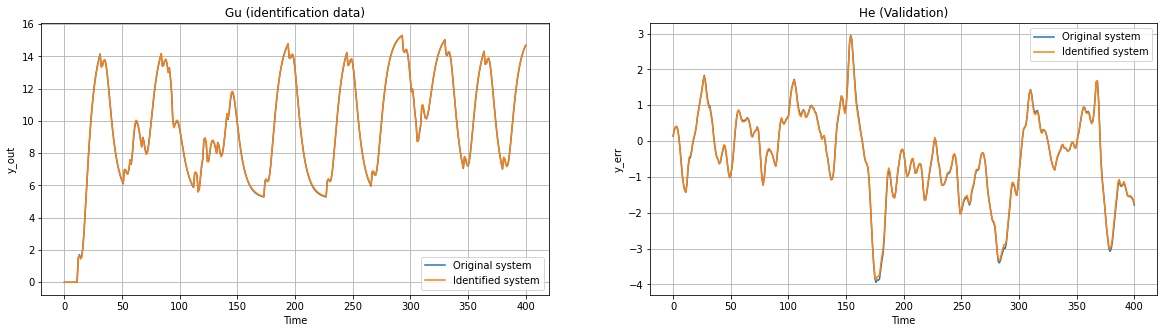

In [42]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
ax.plot(Time, Yvalid1, label="Original system")
ax.plot(Time, Yidvalid1, label="Identified system")
ax.set_title("Gu (identification data)")
ax.set_ylabel("y_out")
ax.set_xlabel("Time")
ax.grid()
ax.legend()


ax = fig.add_subplot(122)
ax.plot(Time, Yvalid2, label="Original system")
ax.plot(Time, Yidvalid2, label="Identified system")
ax.set_xlabel("Time")
ax.set_ylabel("y_err")
ax.set_title("He (Validation)")
ax.grid()
plt.legend()
plt.show()


Original h()


TransferFunction(array([1. , 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ]), array([ 1.       , -2.21     ,  1.7494   , -0.584256 ,  0.0684029,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ]), 1.0)

Identified h()


TransferFunction(array([ 1.        ,  0.34506776, -0.03484606,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ]), array([ 1.        , -2.20855803,  1.7529424 , -0.58679009,  0.06659235,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ]), 1.0)

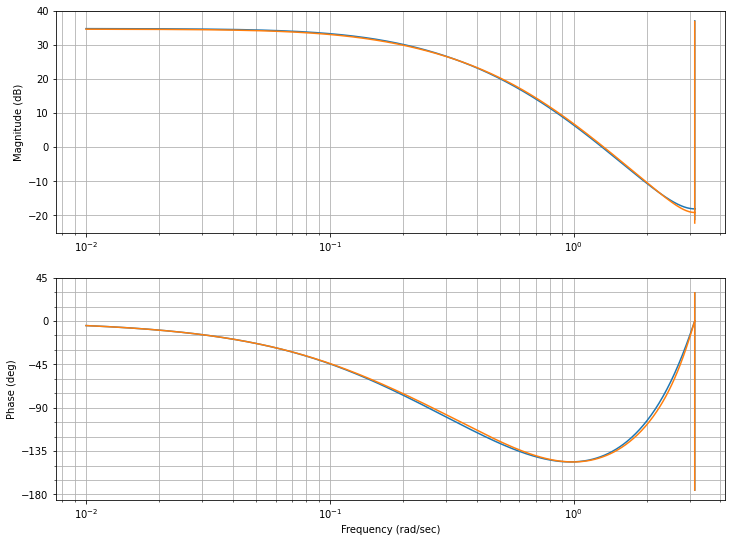

In [46]:
print("Original h()")
display(h_sample)
print("Identified h()")
display(Id_sys.H)

plt.figure(figsize=(12,9))
_ = cnt.bode([h_sample, Id_sys.H])

Original g()


TransferFunction(array([ 1.    , -2.07  ,  1.3146]), array([ 1.       , -2.21     ,  1.7494   , -0.584256 ,  0.0684029,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ]), 1.0)

Identified g()


TransferFunction(array([-0.00809153,  1.00965953, -2.08509751,  1.33510868]), array([ 1.        , -2.20855803,  1.7529424 , -0.58679009,  0.06659235,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ]), 1.0)

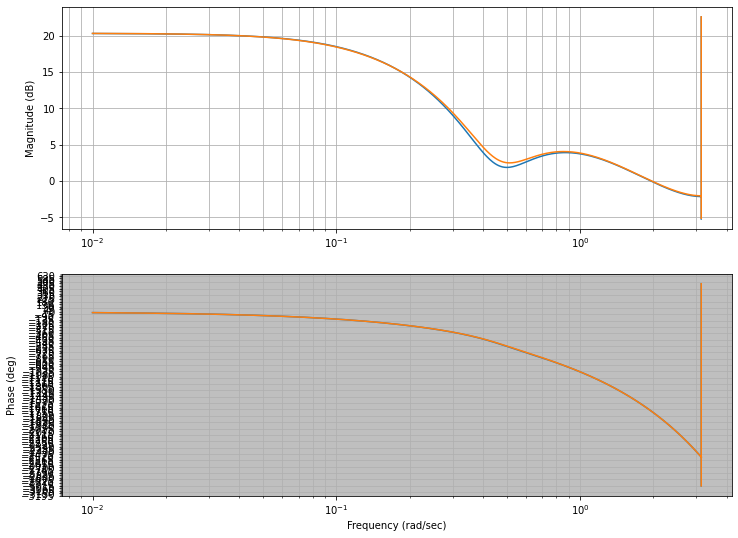

In [45]:
print("Original g()")
display(g_sample)
print("Identified g()")
display(Id_sys.G)

plt.figure(figsize=(12, 9))
_ = cnt.bode([g_sample, Id_sys.G])